#**EXTRAER LOS DATOS DE KAGGLE**

In [ ]:
import os
# siempre colocar el kaggle.json en el colab
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
# ESTE ES EL LINK QUE APARECE DEBAJO DEL DATASET DEL KAGGLE

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.18GB/s]


In [ ]:
!unzip /content/udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Archive:  /content/udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


#**Funciones**

In [ ]:
def mediana(frame, column_name):
    column = frame[column_name]
    if column.isnull().any():
        caracteristic = {}
        no_null_column = column.dropna()
        for i, j in enumerate(no_null_column.unique().tolist()):
            caracteristic[j] = i
        encoded_column = column.map(caracteristic)
        median = int(encoded_column.dropna().median())
        encoded_column = encoded_column.fillna(median)
        reversed_dict = {v: k for k, v in caracteristic.items()}
        decoded_column = encoded_column.map(reversed_dict)
        frame[column_name] = decoded_column
    return frame

def agrupar_clases_poco_frecuentes(df, columna, umbral=0.01, nombre_grupo='otros'):
    frecuencia = df[columna].value_counts(normalize=True)
    clases_poco_frecuentes = frecuencia[frecuencia < umbral].index
    if len(clases_poco_frecuentes) > 1:
      df[columna] = df[columna].replace(clases_poco_frecuentes, nombre_grupo)

In [ ]:
def estilo_categoricas(df, col_num, col_categorica):
    styled_df = df.style.hide(axis="index")

    styled_df = styled_df.set_caption("COLUMNAS CATEGÓRICAS")\
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '12pt'), ('font-weight', '900'), ('text-align', 'left')]},  # Alinear el título
            {'selector': f'th.{col_num}', 'props': [('background-color', '#A8D08D'), ('color', 'black'), ('text-align', 'left')]},  # Alinear título de la columna de número
            {'selector': f'th.{col_categorica}', 'props': [('background-color', '#F4B084'), ('color', 'black'), ('text-align', 'left')]},  # Alinear título de la columna categórica
            {'selector': 'td', 'props': [('text-align', 'left')]}  # Alinear el contenido de todas las celdas a la izquierda
        ])\
        .map(lambda _: 'background-color: midnigth blue', subset=[col_num])\
        .map(lambda _: 'background-color: dark slate blue', subset=[col_categorica])

    return styled_df

#**Librerias**

In [ ]:
# Importamos librerias necesarias
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from progressbar import progressbar as pbar
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Datos de Entrenamiento**


##***CARGA DE DATOS***

In [ ]:
file_path = "/content/train.csv"  # Asegúrate de que este archivo exista en la ruta especificada
data_train = pd.read_csv(file_path, index_col="ID")
print("✅ Datos cargados correctamente")
data_train.head()

✅ Datos cargados correctamente


,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
ID,,,,,,,,,,,,,,,,,,,,
904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [ ]:
# Información general de dataset, sin modiicaciones
print("Información General:")
data_train.info()

Información General:
<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         692500 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             692500 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         661643 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            660363 non-null  object 
 6   FAMI_TIENEINTERNET              665871 non-null  object 
 7   FAMI_EDUCACIONPADRE             669322 non-null  object 
 8   FAMI_TIENELAVADORA              652727 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             648877 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           692500 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        686002 non-null  object 


##***Analisis de Valores Nulos***

In [ ]:
columnas_categoricas=data_train.columns.tolist()[2:16]
print("Porcentaje de los nulos\n")
for columna in columnas_categoricas:
    porcentaje=data_train[columna].isnull().mean()*100
    print(f"El porcentaje de nulos es: {porcentaje:.5f}% en la columna {columna}")
columnas_categoricas=columnas_categoricas[:13]
print(columnas_categoricas)

Porcentaje de los nulos

El porcentaje de nulos es: 0.00000% en la columna ESTU_PRGM_DEPARTAMENTO
El porcentaje de nulos es: 0.90787% en la columna ESTU_VALORMATRICULAUNIVERSIDAD
El porcentaje de nulos es: 4.45588% en la columna ESTU_HORASSEMANATRABAJA
El porcentaje de nulos es: 4.64072% en la columna FAMI_ESTRATOVIVIENDA
El porcentaje de nulos es: 3.84534% en la columna FAMI_TIENEINTERNET
El porcentaje de nulos es: 3.34700% en la columna FAMI_EDUCACIONPADRE
El porcentaje de nulos es: 5.74339% en la columna FAMI_TIENELAVADORA
El porcentaje de nulos es: 6.29935% en la columna FAMI_TIENEAUTOMOVIL
El porcentaje de nulos es: 0.00000% en la columna ESTU_PRIVADO_LIBERTAD
El porcentaje de nulos es: 0.93834% en la columna ESTU_PAGOMATRICULAPROPIO
El porcentaje de nulos es: 5.50224% en la columna FAMI_TIENECOMPUTADOR
El porcentaje de nulos es: 3.84534% en la columna FAMI_TIENEINTERNET.1
El porcentaje de nulos es: 3.41718% en la columna FAMI_EDUCACIONMADRE
El porcentaje de nulos es: 0.00000% en 

In [ ]:
#Dataframes necesarios para el procesamiento de datos
data_train_Preprocesado = data_train.copy()
data_train_Preprocesado2= data_train.copy()
data_train_original=data_train.copy()

In [ ]:
#Se rellenan los valore nulos con la mediana
for i, j in enumerate(columnas_categoricas):
   mediana(data_train_Preprocesado, j)
   mediana(data_train_original, j)
   mediana(data_train_Preprocesado2, j)

In [ ]:
print("Información Preprocesado:")
data_train_Preprocesado.info()

Información Preprocesado:
<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         692500 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             692500 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         692500 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            692500 non-null  object 
 6   FAMI_TIENEINTERNET              692500 non-null  object 
 7   FAMI_EDUCACIONPADRE             692500 non-null  object 
 8   FAMI_TIENELAVADORA              692500 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             692500 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           692500 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        692500 non-null  obj

In [ ]:
print("Información Original:")
data_train_original.info()

Información Original:
<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         692500 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             692500 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         692500 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            692500 non-null  object 
 6   FAMI_TIENEINTERNET              692500 non-null  object 
 7   FAMI_EDUCACIONPADRE             692500 non-null  object 
 8   FAMI_TIENELAVADORA              692500 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             692500 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           692500 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        692500 non-null  object 

In [ ]:
print("Información Preprocesado2:")
data_train_Preprocesado2.info()

Información Preprocesado2:
<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         692500 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             692500 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         692500 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            692500 non-null  object 
 6   FAMI_TIENEINTERNET              692500 non-null  object 
 7   FAMI_EDUCACIONPADRE             692500 non-null  object 
 8   FAMI_TIENELAVADORA              692500 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             692500 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           692500 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        692500 non-null  ob

##***Eliminacion de Columnas de alta Cardinalidad***

In [ ]:
data_train_Preprocesado=data_train_Preprocesado.drop(["ESTU_PRGM_ACADEMICO"], axis=1)
data_train_Preprocesado2=data_train_Preprocesado2.drop(["ESTU_PRGM_ACADEMICO"], axis=1)
data_train_original=data_train_original.drop(["ESTU_PRGM_ACADEMICO"], axis=1)

##***Agrupamiento de velores de columna que son menores al 1%***

In [ ]:
for i in columnas_categoricas[0:13]:
    agrupar_clases_poco_frecuentes(data_train_Preprocesado, i, umbral=0.01, nombre_grupo='OTROS')
    agrupar_clases_poco_frecuentes(data_train_Preprocesado2, i, umbral=0.01, nombre_grupo='OTROS')

In [ ]:
#El Preprocesado 2 contara con las columnas de mayor correlacion vistas en la exploaqcionn de
Columnas_totales=data_train_Preprocesado2.columns.tolist()
columnnas_eliminar = set(Columnas_totales).difference({"ESTU_VALORMATRICULAUNIVERSIDAD","FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE","RENDIMIENTO_GLOBAL",'coef_1', 'coef_2', 'coef_3', 'coef_4'})
data_train_Preprocesado2 = data_train_Preprocesado2.drop(list(columnnas_eliminar), axis=1)
print(f"Variables totales: {Columnas_totales}")
print(f"Variables del Proceado2: {data_train_Preprocesado2.columns.tolist()}")


Variables totales: ['PERIODO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']
Variables del Proceado2: ['ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']


##***Comparacion Antes y despues del Agrupamientos de terminos por columna***

In [ ]:
#Preprocesado-1
for col in Columnas_totales:
    print(f"\n Columna: {col}")
    uniques_Preprocesado = set(data_train_Preprocesado[col].dropna().unique())
    uniques_muestra = set(data_train_original[col].dropna().unique())

    print(f"Valores únicos en 'data_train_con_Agrupamiento': {sorted(uniques_Preprocesado)}")
    print(f"Valores únicos en 'data_train_Orginal': {sorted(uniques_muestra)}")

    diferencia = uniques_muestra - uniques_Preprocesado
    if diferencia:
        print("Diferencias:")
        print(sorted(diferencia))
    else:
        print(" No hay diferencias entre los datasets.")



 Columna: PERIODO
Valores únicos en 'data_train_con_Agrupamiento': [np.int64(20183), np.int64(20184), np.int64(20194), np.int64(20195), np.int64(20196), np.int64(20202), np.int64(20203), np.int64(20212), np.int64(20213)]
Valores únicos en 'data_train_Orginal': [np.int64(20183), np.int64(20184), np.int64(20194), np.int64(20195), np.int64(20196), np.int64(20202), np.int64(20203), np.int64(20212), np.int64(20213)]
 No hay diferencias entre los datasets.

 Columna: ESTU_PRGM_DEPARTAMENTO
Valores únicos en 'data_train_con_Agrupamiento': ['ANTIOQUIA', 'ATLANTICO', 'BOGOTÁ', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAUCA', 'CESAR', 'CORDOBA', 'CUNDINAMARCA', 'HUILA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE SANTANDER', 'OTROS', 'QUINDIO', 'RISARALDA', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE']
Valores únicos en 'data_train_Orginal': ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTÁ', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'GUAVIAR

In [ ]:
columas_Preprocesado2=data_train_Preprocesado2.columns.tolist()

for col in columas_Preprocesado2:
    print(f"\n Columna: {col}")
    uniques_Preprocesado2 = set(data_train_Preprocesado2[col].dropna().unique())
    uniques_muestra = set(data_train_original[col].dropna().unique())

    print(f"Valores únicos en 'data_train_Agrupamiento': {sorted(uniques_Preprocesado2)}")
    print(f"Valores únicos en 'data_train_Original': {sorted(uniques_muestra)}")

    diferencia = uniques_muestra - uniques_Preprocesado2
    if diferencia:
        print("Diferencias:")
        print(sorted(diferencia))
    else:
        print(" No hay diferencias entre los datasets.")


 Columna: ESTU_VALORMATRICULAUNIVERSIDAD
Valores únicos en 'data_train_Agrupamiento': ['Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones', 'Entre 500 mil y menos de 1 millón', 'Menos de 500 mil', 'Más de 7 millones', 'No pagó matrícula']
Valores únicos en 'data_train_Original': ['Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones', 'Entre 500 mil y menos de 1 millón', 'Menos de 500 mil', 'Más de 7 millones', 'No pagó matrícula']
 No hay diferencias entre los datasets.

 Columna: FAMI_ESTRATOVIVIENDA
Valores únicos en 'data_train_Agrupamiento': ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6', 'Sin Estrato']
Valores únicos en 'data_train_Original': ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estra

##***Variable Target***

In [ ]:
# Mapeo manual con orden lógico
orden_personalizado = {
    "bajo": 0,
    "medio-bajo": 1,
    "medio-alto": 2,
    "alto": 3
}

# Aplicar el mapeo a la columna
Target = data_train_original["RENDIMIENTO_GLOBAL"].map(orden_personalizado)

# Mostrar el mapeo aplicado
print("EL procentaje que equivale cada respuesta con respecto al Total")
print(Target.value_counts(normalize=True).sort_index())

# Mostrar el mapeo para referencia
print("\nMapeo utilizado:")
for key, val in orden_personalizado.items():
    print(f"{key}: {val}")



EL procentaje que equivale cada respuesta con respecto al Total
RENDIMIENTO_GLOBAL
0    0.249801
1    0.248773
2    0.247825
3    0.253601
Name: proportion, dtype: float64

Mapeo utilizado:
bajo: 0
medio-bajo: 1
medio-alto: 2
alto: 3


## ***Evaluación de la Relevancia de Variables Categóricas frente a la Variable Objetivo***

In [ ]:
x_label_Preprocesado = data_train_Preprocesado[Columnas_totales].apply(LabelEncoder().fit_transform)
chi_scores, _ = chi2(x_label_Preprocesado, Target)

chi2_df = pd.DataFrame({
    'Variable': Columnas_totales,
    'Chi2_Score': chi_scores
})

p_values = []
for var in Columnas_totales:
    table = pd.crosstab(data_train_Preprocesado[var], data_train_Preprocesado['RENDIMIENTO_GLOBAL'])
    chi2_stat, p, dof, expected = chi2_contingency(table)
    p_values.append(p)

chi2_df['P_Value'] = p_values
chi2_df = chi2_df.round({'Chi2_Score': 4, 'P_Value': 2})
chi2_df['P_Value'] = chi2_df['P_Value'].apply(lambda x: f"{x:.2f}")
chi2_df['Importance'] = chi2_df['P_Value'].apply(lambda x: 'Importante' if float(x) < 0.05 else 'no Importante')
chi2_df.sort_values(by='Chi2_Score', ascending=False, inplace=True)

display(chi2_df)

,Variable,Chi2_Score,P_Value,Importance
15,coef_1,1.200154e+06,0.00,Importante
16,coef_2,5.924244e+05,0.00,Importante
14,RENDIMIENTO_GLOBAL,5.824401e+05,0.00,Importante
18,coef_4,2.977286e+05,0.00,Importante
2,ESTU_VALORMATRICULAUNIVERSIDAD,1.128909e+05,0.00,Importante
4,FAMI_ESTRATOVIVIENDA,3.724757e+04,0.00,Importante
17,coef_3,3.477622e+04,0.00,Importante
13,FAMI_EDUCACIONMADRE,1.643674e+04,0.00,Importante
10,ESTU_PAGOMATRICULAPROPIO,1.578653e+04,0.00,Importante
6,FAMI_EDUCACIONPADRE,1.456459e+04,0.00,Importante


### ***Columnas Redundantes***

In [ ]:
umbral = 0.80
duplicadas_flexibles = []

for i in range(len(Columnas_totales)):
    for j in range(i + 1, len(Columnas_totales)):
        col1 = Columnas_totales[i]
        col2 = Columnas_totales[j]
        iguales = (data_train_Preprocesado[col1] == data_train_Preprocesado[col2])
        porcentaje_iguales = iguales.mean()
        if porcentaje_iguales > umbral:
            duplicadas_flexibles.append((col1, col2, porcentaje_iguales))

print("Columnas categóricas que son casi iguales:")
for par in duplicadas_flexibles:
    print(f"{par[0]} y {par[1]}: {par[2]*100:.2f}% iguales")

Columnas categóricas que son casi iguales:
FAMI_TIENEINTERNET y FAMI_TIENELAVADORA: 84.84% iguales
FAMI_TIENEINTERNET y FAMI_TIENECOMPUTADOR: 90.19% iguales
FAMI_TIENEINTERNET y FAMI_TIENEINTERNET.1: 100.00% iguales
FAMI_TIENELAVADORA y FAMI_TIENECOMPUTADOR: 84.86% iguales
FAMI_TIENELAVADORA y FAMI_TIENEINTERNET.1: 84.84% iguales
FAMI_TIENECOMPUTADOR y FAMI_TIENEINTERNET.1: 90.19% iguales


##***Eliminacion de columnas similares***





In [ ]:
data_train_Preprocesado.pop("FAMI_TIENEINTERNET.1");
data_train_Preprocesado.pop("FAMI_TIENEINTERNET");
data_train_Preprocesado.pop("FAMI_TIENELAVADORA");
data_train_Preprocesado.pop("ESTU_PRIVADO_LIBERTAD");

## ***Transformación de Variables Categoricas***

In [ ]:
data_train_Procesado_dummies=data_train_Preprocesado.copy()

In [ ]:
print(data_train_Preprocesado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         692500 non-null  int64  
 1   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 2   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  object 
 3   ESTU_HORASSEMANATRABAJA         692500 non-null  object 
 4   FAMI_ESTRATOVIVIENDA            692500 non-null  object 
 5   FAMI_EDUCACIONPADRE             692500 non-null  object 
 6   FAMI_TIENEAUTOMOVIL             692500 non-null  object 
 7   ESTU_PAGOMATRICULAPROPIO        692500 non-null  object 
 8   FAMI_TIENECOMPUTADOR            692500 non-null  object 
 9   FAMI_EDUCACIONMADRE             692500 non-null  object 
 10  RENDIMIENTO_GLOBAL              692500 non-null  object 
 11  coef_1                          692500 non-null  float64
 12  coef_2          

In [ ]:
cols = list(data_train_Preprocesado.columns)
cols.remove('FAMI_EDUCACIONMADRE')
cols.insert(6, 'FAMI_EDUCACIONMADRE')
data_train_Preprocesado = data_train_Preprocesado[cols]


In [ ]:
print(data_train_Preprocesado.info())
data_train_Preprocesado.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         692500 non-null  int64  
 1   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 2   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  object 
 3   ESTU_HORASSEMANATRABAJA         692500 non-null  object 
 4   FAMI_ESTRATOVIVIENDA            692500 non-null  object 
 5   FAMI_EDUCACIONPADRE             692500 non-null  object 
 6   FAMI_EDUCACIONMADRE             692500 non-null  object 
 7   FAMI_TIENEAUTOMOVIL             692500 non-null  object 
 8   ESTU_PAGOMATRICULAPROPIO        692500 non-null  object 
 9   FAMI_TIENECOMPUTADOR            692500 non-null  object 
 10  RENDIMIENTO_GLOBAL              692500 non-null  object 
 11  coef_1                          692500 non-null  float64
 12  coef_2          

['PERIODO',
 'ESTU_PRGM_DEPARTAMENTO',
 'ESTU_VALORMATRICULAUNIVERSIDAD',
 'ESTU_HORASSEMANATRABAJA',
 'FAMI_ESTRATOVIVIENDA',
 'FAMI_EDUCACIONPADRE',
 'FAMI_EDUCACIONMADRE',
 'FAMI_TIENEAUTOMOVIL',
 'ESTU_PAGOMATRICULAPROPIO',
 'FAMI_TIENECOMPUTADOR',
 'RENDIMIENTO_GLOBAL',
 'coef_1',
 'coef_2',
 'coef_3',
 'coef_4']

In [ ]:
data_train_Preprocesado3= data_train_Preprocesado.copy()

##***Primer Dataframe, Enconding sin one Hot***

In [ ]:

# ========== 1. Codificación ALEATORIA INDIVIDUAL ==========
np.random.seed(42)  # Para reproducibilidad

# Codificación aleatoria de PERIODO
unique_periodos = data_train_Preprocesado['PERIODO'].unique()
periodo_mapping = dict(zip(unique_periodos, np.random.permutation(len(unique_periodos))))
data_train_Preprocesado['PERIODO_random_encode'] = data_train_Preprocesado['PERIODO'].map(periodo_mapping)

# Codificación aleatoria de ESTU_PRGM_DEPARTAMENTO
unique_departamentos = data_train_Preprocesado['ESTU_PRGM_DEPARTAMENTO'].unique()
departamento_mapping = dict(zip(unique_departamentos, np.random.permutation(len(unique_departamentos))))
data_train_Preprocesado['ESTU_PRGM_DEPARTAMENTO_random_encode'] = data_train_Preprocesado['ESTU_PRGM_DEPARTAMENTO'].map(departamento_mapping)

# --- 2. Codificación ORDINAL: 5 columnas ---

trabajo_orden = [
    '0',
    'Menos de 10 horas',
    'Entre 11 y 20 horas',
    'Entre 21 y 30 horas',
    'Más de 30 horas'
]

estrato_orden = [
    'Sin Estrato',
    'Estrato 1',
    'Estrato 2',
    'Estrato 3',
    'Estrato 4',
    'Estrato 5',
    'Estrato 6'
]

educacion_orden = [
    'Ninguno',
    'Primaria incompleta',
    'Primaria completa',
    'Secundaria (Bachillerato) incompleta',
    'Secundaria (Bachillerato) completa',
    'Técnica o tecnológica incompleta',
    'Técnica o tecnológica completa',
    'Educación profesional incompleta',
    'Educación profesional completa',
    'Postgrado',
    'No sabe',
    'No Aplica',
    'OTROS'
]

matricula_orden = [
    'No pagó matrícula',
    'Menos de 500 mil',
    'Entre 500 mil y menos de 1 millón',
    'Entre 1 millón y menos de 2.5 millones',
    'Entre 2.5 millones y menos de 4 millones',
    'Entre 4 millones y menos de 5.5 millones',
    'Entre 5.5 millones y menos de 7 millones',
    'Más de 7 millones'
]

ordinal_mappings = {
    'ESTU_HORASSEMANATRABAJA': trabajo_orden,
    'FAMI_ESTRATOVIVIENDA': estrato_orden,
    'FAMI_EDUCACIONPADRE': educacion_orden,
    'FAMI_EDUCACIONMADRE': educacion_orden,
    'ESTU_VALORMATRICULAUNIVERSIDAD': matricula_orden
}

for col, order in ordinal_mappings.items():
    data_train_Preprocesado[col + '_ordinal'] = pd.Categorical(data_train_Preprocesado[col], categories=order, ordered=True).codes

# --- 3. Codificación BINARIA: 3 columnas ---
binary_map = {'Si': 1, 'No': 0}

for col in ['FAMI_TIENEAUTOMOVIL', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR']:
    data_train_Preprocesado[col + '_bin'] = data_train_Preprocesado[col].map(binary_map)


In [ ]:
data_train_Preprocesado=data_train_Preprocesado[data_train_Preprocesado.columns.tolist()[11:]]

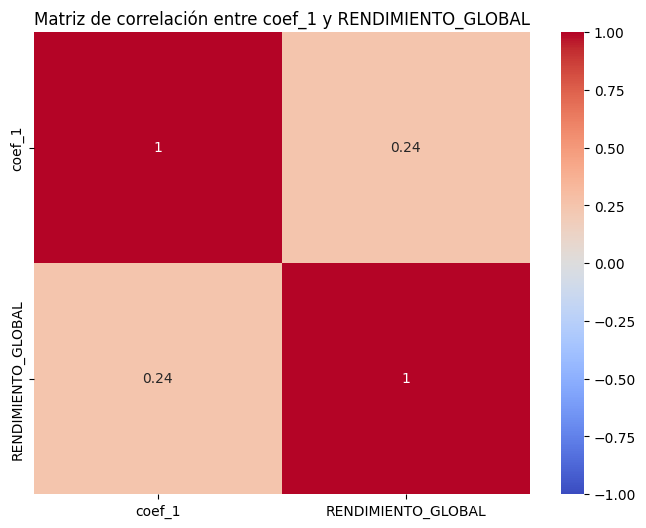

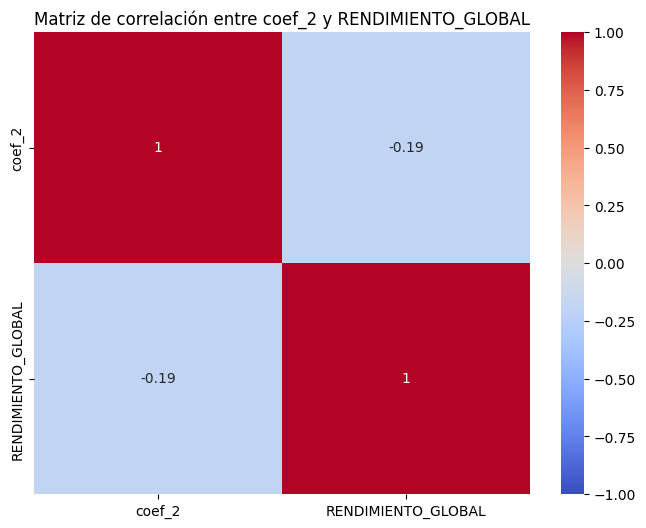

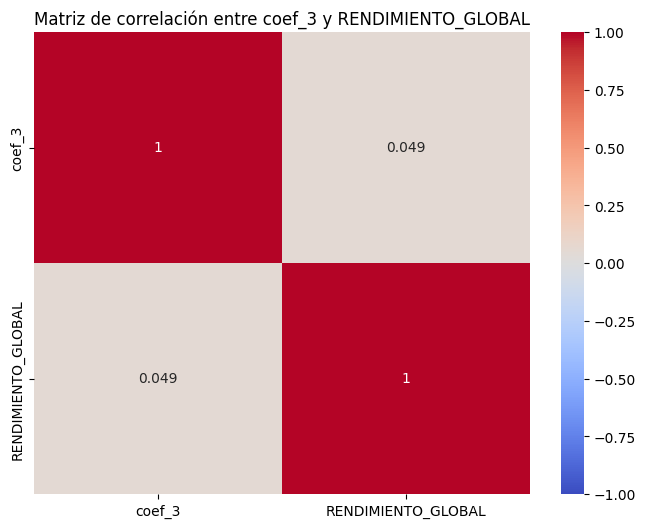

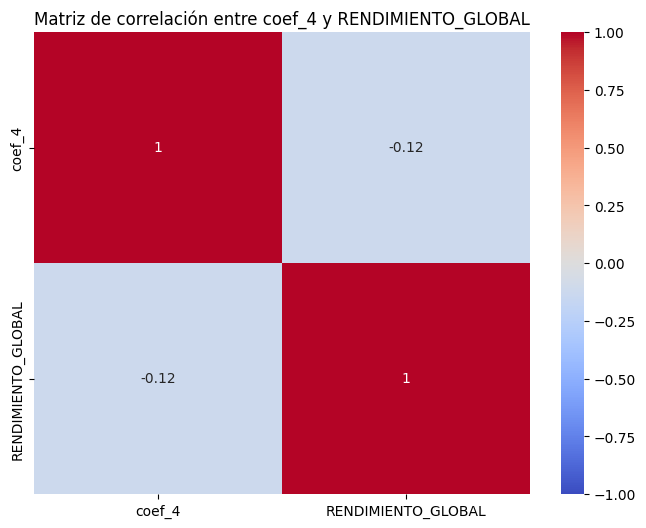

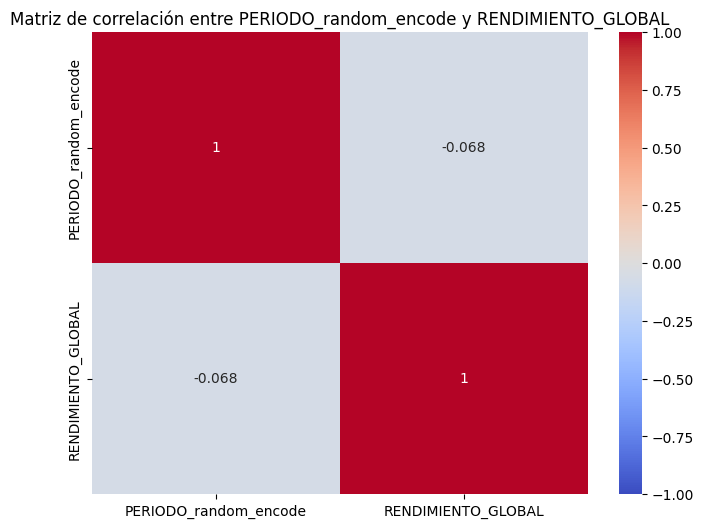

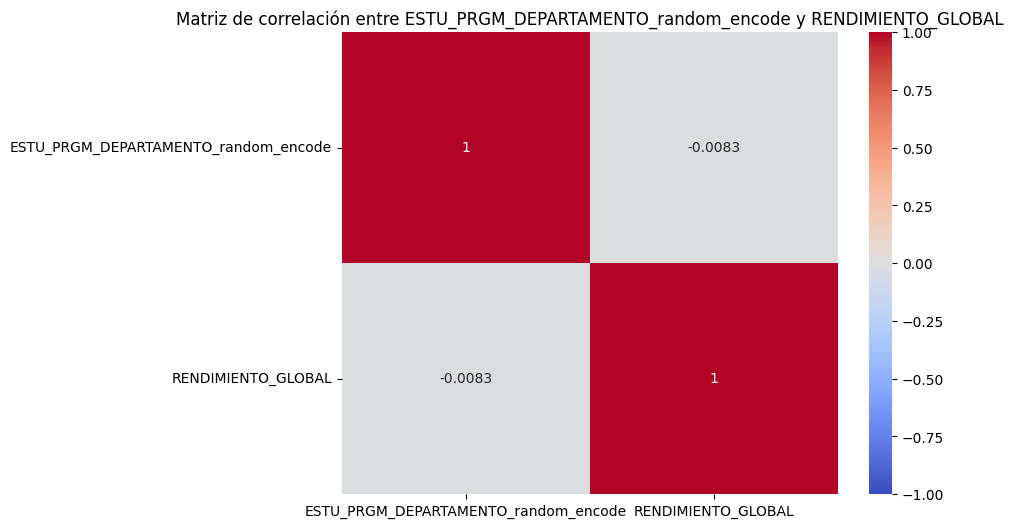

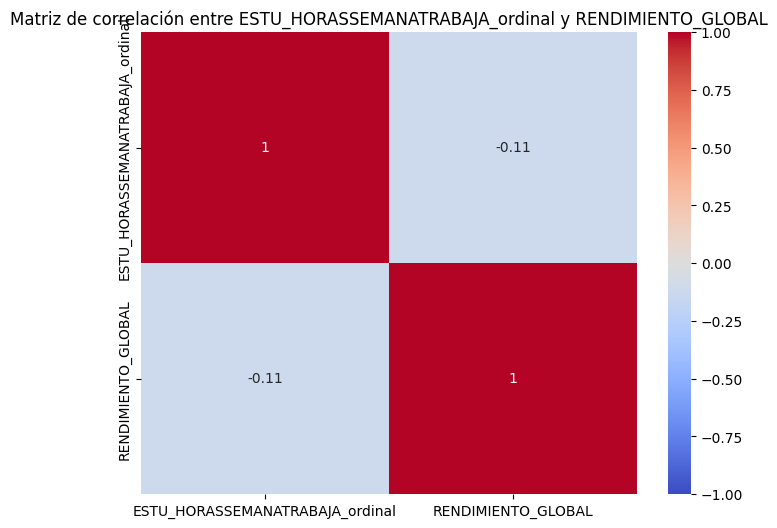

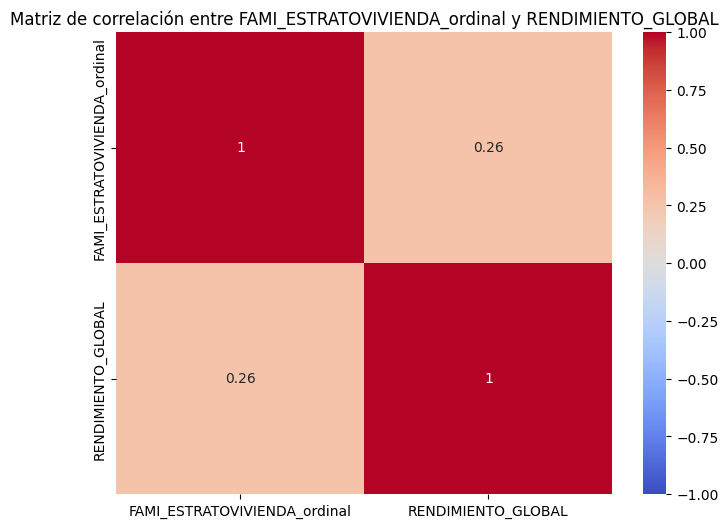

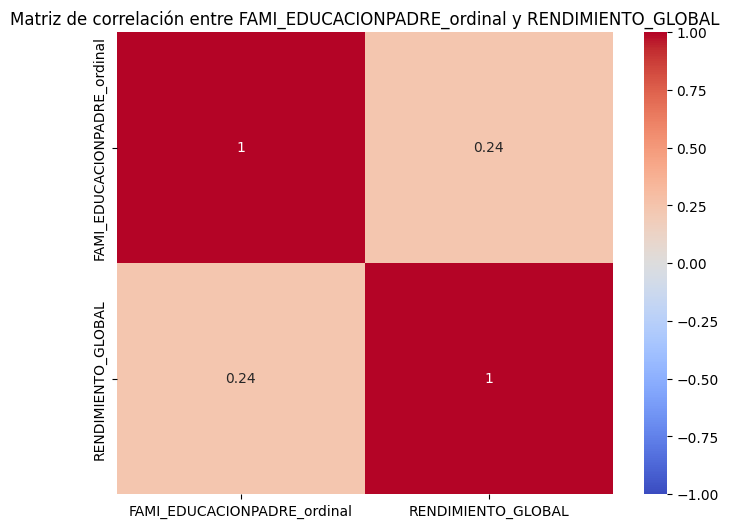

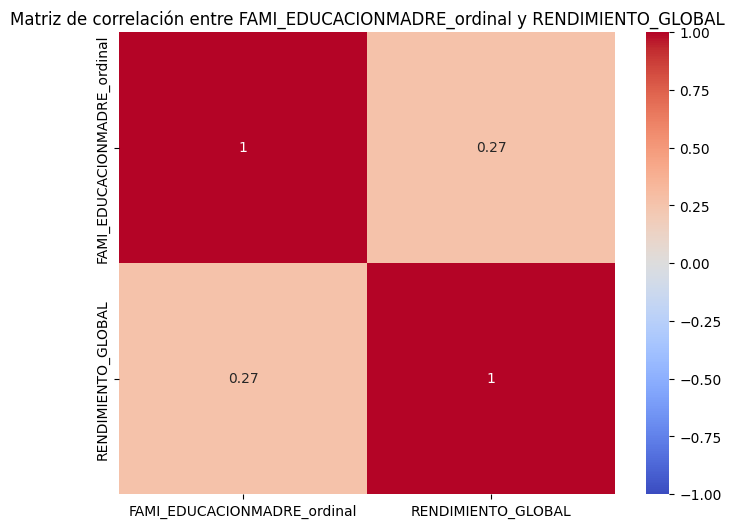

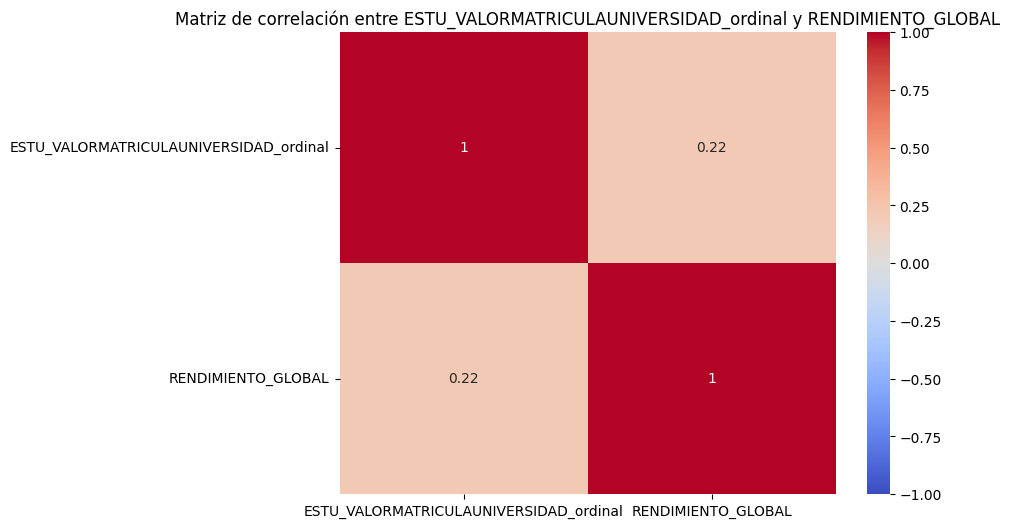

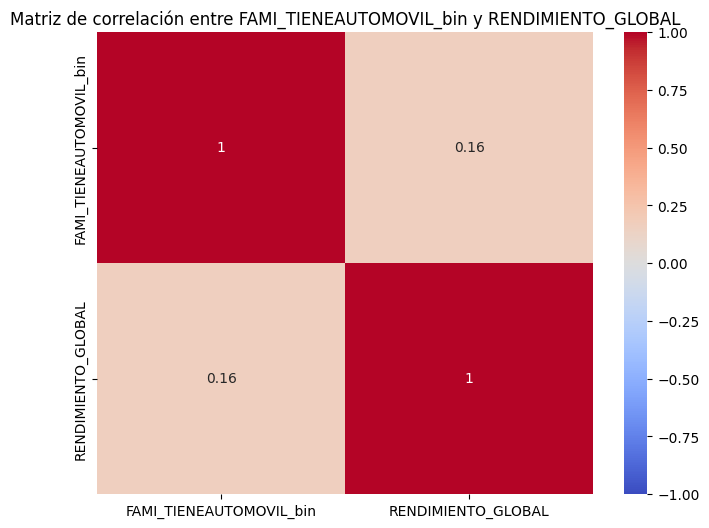

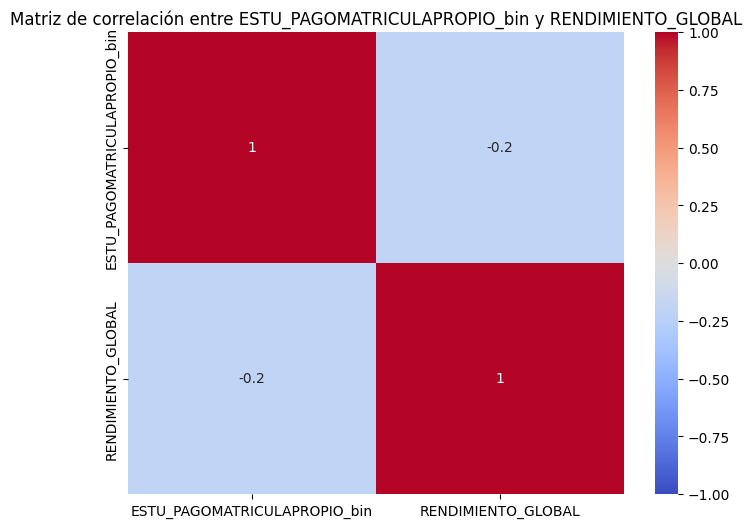

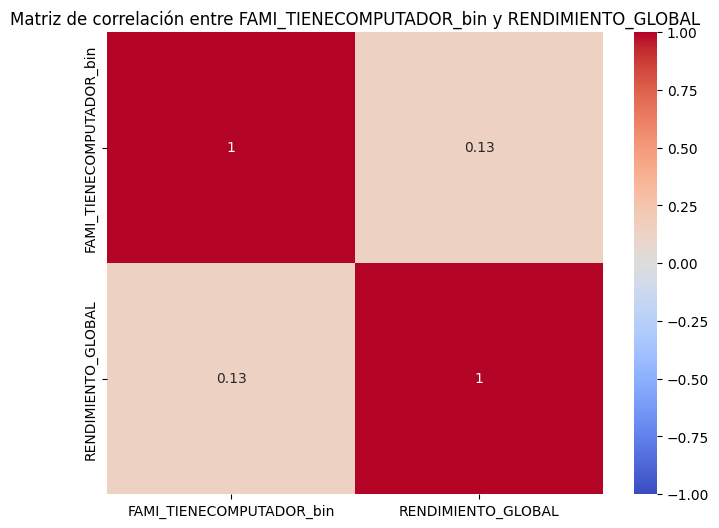

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas if not already imported

for i in data_train_Preprocesado.columns.tolist():
  plt.figure(figsize=(8, 6))
  # Create a temporary DataFrame with the current column and the Target series
  temp_df = pd.concat([data_train_Preprocesado[i], Target.rename('RENDIMIENTO_GLOBAL')], axis=1)
  # Calculate and plot the correlation heatmap for the temporary DataFrame
  sns.heatmap(temp_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(f"Matriz de correlación entre {i} y RENDIMIENTO_GLOBAL")
  plt.show()

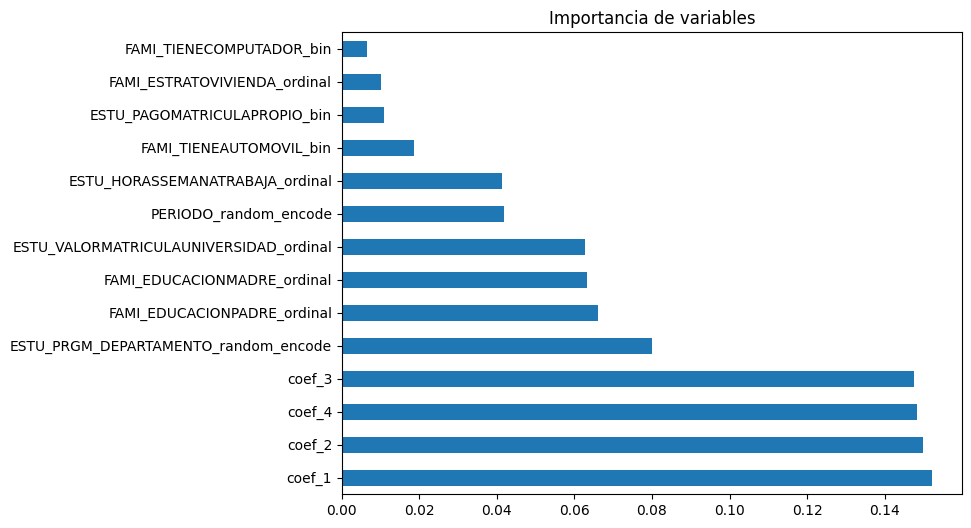

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf = RandomForestClassifier()
rf.fit(data_train_Preprocesado, Target)

importances = pd.Series(rf.feature_importances_, index=data_train_Preprocesado.columns)
importances.nlargest(15).plot(kind='barh', figsize=(8, 6), title="Importancia de variables")
plt.show()

##**Segundo Dataframe, Reducido con los datos de exploracion**

In [ ]:
print(data_train_Preprocesado2.columns.tolist())
columnas_drop=data_train_Preprocesado2.columns.tolist()

['ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
data_train_Preprocesado2[columnas_drop[0:4]] = encoder.fit_transform(data_train_Preprocesado2[columnas_drop[0:4]])

In [ ]:
data_train_Preprocesado2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ESTU_VALORMATRICULAUNIVERSIDAD  692500 non-null  float64
 1   FAMI_ESTRATOVIVIENDA            692500 non-null  float64
 2   FAMI_EDUCACIONPADRE             692500 non-null  float64
 3   FAMI_EDUCACIONMADRE             692500 non-null  float64
 4   RENDIMIENTO_GLOBAL              692500 non-null  object 
 5   coef_1                          692500 non-null  float64
 6   coef_2                          692500 non-null  float64
 7   coef_3                          692500 non-null  float64
 8   coef_4                          692500 non-null  float64
dtypes: float64(8), object(1)
memory usage: 52.8+ MB


##***Tercer Dataframe, con departamentos en one-hot***

In [ ]:
data_train_Preprocesado3=pd.get_dummies(data_train_Preprocesado3, columns=['ESTU_PRGM_DEPARTAMENTO'])
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

data_train_Preprocesado3[columnas_categoricas[1:4]] = encoder.fit_transform(data_train_Preprocesado3[columnas_categoricas[1:4]])
data_train_Preprocesado3[["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"]]=encoder.fit_transform(data_train_Preprocesado3[["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"]])

le = LabelEncoder()
for i in ['FAMI_TIENEAUTOMOVIL', 'ESTU_PAGOMATRICULAPROPIO',"FAMI_TIENECOMPUTADOR"]:
  data_train_Preprocesado3[i] = le.fit_transform(data_train_Preprocesado3[i])

In [ ]:
data_train_Preprocesado3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692500 entries, 904256 to 933374
Data columns (total 36 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   PERIODO                                 692500 non-null  int64  
 1   ESTU_VALORMATRICULAUNIVERSIDAD          692500 non-null  float64
 2   ESTU_HORASSEMANATRABAJA                 692500 non-null  float64
 3   FAMI_ESTRATOVIVIENDA                    692500 non-null  float64
 4   FAMI_EDUCACIONPADRE                     692500 non-null  float64
 5   FAMI_EDUCACIONMADRE                     692500 non-null  float64
 6   FAMI_TIENEAUTOMOVIL                     692500 non-null  int64  
 7   ESTU_PAGOMATRICULAPROPIO                692500 non-null  int64  
 8   FAMI_TIENECOMPUTADOR                    692500 non-null  int64  
 9   RENDIMIENTO_GLOBAL                      692500 non-null  object 
 10  coef_1                                  6925

##**Cuarto Dataframe, Todo one-hot***

In [ ]:
columas_dummies=data_train_Procesado_dummies.columns.tolist()
data_train_Procesado_dummies_2=pd.get_dummies(data_train_Procesado_dummies, columns=columas_dummies[:-5])*1

In [ ]:
print(data_train_Procesado_dummies_2.head())

       RENDIMIENTO_GLOBAL  coef_1  coef_2  coef_3  coef_4  PERIODO_20183  \
ID                                                                         
904256         medio-alto   0.322   0.208   0.310   0.267              0   
645256               bajo   0.311   0.215   0.292   0.264              0   
308367               bajo   0.297   0.214   0.305   0.264              0   
470353               alto   0.485   0.172   0.252   0.190              0   
989032         medio-bajo   0.316   0.232   0.285   0.294              0   

        PERIODO_20184  PERIODO_20194  PERIODO_20195  PERIODO_20196  ...  \
ID                                                                  ...   
904256              0              0              0              0  ...   
645256              0              0              0              0  ...   
308367              0              0              0              0  ...   
470353              0              0              1              0  ...   
989032           

#**Datos de Testeo**







##**Carga de Datos**

In [ ]:
file_path = "/content/test.csv"  # Asegúrate de que este archivo exista en la ruta especificada
data_test = pd.read_csv(file_path, index_col="ID")
print("✅ Datos cargados correctamente")
data_test.head()

✅ Datos cargados correctamente


,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,coef_1,coef_2,coef_3,coef_4
ID,,,,,,,,,,,,,,,,,,,
550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247
782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Si,No,N,No,No,No,Primaria incompleta,0.160,0.408,0.217,0.294
785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.209,0.283,0.306,0.286


In [ ]:
print("Información General:")
data_test.info()

Información General:
<class 'pandas.core.frame.DataFrame'>
Index: 296786 entries, 550236 to 792650
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         296786 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             296786 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          296786 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  294063 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         283407 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            282991 non-null  object 
 6   FAMI_TIENEINTERNET              285247 non-null  object 
 7   FAMI_EDUCACIONPADRE             286793 non-null  object 
 8   FAMI_TIENELAVADORA              279527 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             277868 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           296786 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        293979 non-null  object 


##***Analisis de Valores Nulos***

In [ ]:
print("Porcentaje de los nulos\n")
for columna in columnas_categoricas:
    porcentaje=data_test[columna].isnull().mean()*100
    print(f"El porcentaje de nulos es: {porcentaje:.5f}% en la columna {columna}")

Porcentaje de los nulos

El porcentaje de nulos es: 0.00000% en la columna ESTU_PRGM_DEPARTAMENTO
El porcentaje de nulos es: 0.91750% en la columna ESTU_VALORMATRICULAUNIVERSIDAD
El porcentaje de nulos es: 4.50796% en la columna ESTU_HORASSEMANATRABAJA
El porcentaje de nulos es: 4.64813% en la columna FAMI_ESTRATOVIVIENDA
El porcentaje de nulos es: 3.88799% en la columna FAMI_TIENEINTERNET
El porcentaje de nulos es: 3.36707% en la columna FAMI_EDUCACIONPADRE
El porcentaje de nulos es: 5.81530% en la columna FAMI_TIENELAVADORA
El porcentaje de nulos es: 6.37429% en la columna FAMI_TIENEAUTOMOVIL
El porcentaje de nulos es: 0.00000% en la columna ESTU_PRIVADO_LIBERTAD
El porcentaje de nulos es: 0.94580% en la columna ESTU_PAGOMATRICULAPROPIO
El porcentaje de nulos es: 5.53901% en la columna FAMI_TIENECOMPUTADOR
El porcentaje de nulos es: 3.88799% en la columna FAMI_TIENEINTERNET.1
El porcentaje de nulos es: 3.44457% en la columna FAMI_EDUCACIONMADRE


In [ ]:
data_test_Preprocesado = data_test.copy()
data_test_Preprocesado2= data_test.copy()
data_test_original=data_test.copy()

In [ ]:
for i,j in enumerate(columnas_categoricas):
    mediana(data_test_Preprocesado,j)
    mediana(data_test_Preprocesado2,j)
    mediana(data_test_original,j)

In [ ]:
print("Información General:")
data_test_Preprocesado.info()

Información General:
<class 'pandas.core.frame.DataFrame'>
Index: 296786 entries, 550236 to 792650
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         296786 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             296786 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          296786 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  296786 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         296786 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            296786 non-null  object 
 6   FAMI_TIENEINTERNET              296786 non-null  object 
 7   FAMI_EDUCACIONPADRE             296786 non-null  object 
 8   FAMI_TIENELAVADORA              296786 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             296786 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           296786 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        296786 non-null  object 


In [ ]:
print("Información General:")
data_test_Preprocesado2.info()

Información General:
<class 'pandas.core.frame.DataFrame'>
Index: 296786 entries, 550236 to 792650
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         296786 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             296786 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          296786 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  296786 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         296786 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            296786 non-null  object 
 6   FAMI_TIENEINTERNET              296786 non-null  object 
 7   FAMI_EDUCACIONPADRE             296786 non-null  object 
 8   FAMI_TIENELAVADORA              296786 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             296786 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           296786 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        296786 non-null  object 


In [ ]:
print("Información General:")
data_test_original.info()

Información General:
<class 'pandas.core.frame.DataFrame'>
Index: 296786 entries, 550236 to 792650
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERIODO                         296786 non-null  int64  
 1   ESTU_PRGM_ACADEMICO             296786 non-null  object 
 2   ESTU_PRGM_DEPARTAMENTO          296786 non-null  object 
 3   ESTU_VALORMATRICULAUNIVERSIDAD  296786 non-null  object 
 4   ESTU_HORASSEMANATRABAJA         296786 non-null  object 
 5   FAMI_ESTRATOVIVIENDA            296786 non-null  object 
 6   FAMI_TIENEINTERNET              296786 non-null  object 
 7   FAMI_EDUCACIONPADRE             296786 non-null  object 
 8   FAMI_TIENELAVADORA              296786 non-null  object 
 9   FAMI_TIENEAUTOMOVIL             296786 non-null  object 
 10  ESTU_PRIVADO_LIBERTAD           296786 non-null  object 
 11  ESTU_PAGOMATRICULAPROPIO        296786 non-null  object 


## ***Eliminacion de Columnas de Alta Cardinalidad***

In [ ]:
data_test_Preprocesado=data_test_Preprocesado.drop(["ESTU_PRGM_ACADEMICO"], axis=1)
data_test_Preprocesado2=data_test_Preprocesado2.drop(["ESTU_PRGM_ACADEMICO"], axis=1)
data_test_original=data_test_original.drop(["ESTU_PRGM_ACADEMICO"], axis=1)

##***Agrupamiento de velores de columna que son menores al 1%***

In [ ]:
for i in columnas_categoricas[0:13]:
    agrupar_clases_poco_frecuentes(data_test_Preprocesado2, i, umbral=0.01, nombre_grupo='OTROS')
    agrupar_clases_poco_frecuentes(data_test_Preprocesado, i, umbral=0.01, nombre_grupo='OTROS')

In [ ]:
#El Preprocesado 2 contara con las columnas de mayor correlacion vistas en la exploaqcionn de
Columnas_totales=data_test_Preprocesado2.columns.tolist()
columnnas_eliminar = set(Columnas_totales).difference({"ESTU_VALORMATRICULAUNIVERSIDAD","FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE","RENDIMIENTO_GLOBAL",'coef_1', 'coef_2', 'coef_3', 'coef_4'})
data_test_Preprocesado2 = data_test_Preprocesado2.drop(list(columnnas_eliminar), axis=1)
print(f"Variables totales: {Columnas_totales}")
print(f"Variables del Proceado2: {data_test_Preprocesado2.columns.tolist()}")

Variables totales: ['PERIODO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'coef_1', 'coef_2', 'coef_3', 'coef_4']
Variables del Proceado2: ['ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'coef_1', 'coef_2', 'coef_3', 'coef_4']


##***Comparacion Antes y despues del Agrupamientos de terminos por columna***

In [ ]:
for col in columnas_categoricas:
    print(f"\n Columna: {col}")
    uniques_Preprocesado = set(data_test_Preprocesado[col].dropna().unique())
    uniques_muestra = set(data_test_original[col].dropna().unique())

    print(f"Valores únicos en 'data_test_Preprocesado': {sorted(uniques_Preprocesado)}")
    print(f"Valores únicos en 'data_test_original': {sorted(uniques_muestra)}")

    diferencia = uniques_muestra - uniques_Preprocesado
    if diferencia:
        print("Diferencias:")
        print(sorted(diferencia))
    else:
        print("No hay diferencias entre los datasets.")



 Columna: ESTU_PRGM_DEPARTAMENTO
Valores únicos en 'data_test_Preprocesado': ['ANTIOQUIA', 'ATLANTICO', 'BOGOTÁ', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAUCA', 'CESAR', 'CORDOBA', 'CUNDINAMARCA', 'HUILA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE SANTANDER', 'OTROS', 'QUINDIO', 'RISARALDA', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE']
Valores únicos en 'data_test_original': ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTÁ', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SAN ANDRES', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE', 'VAUPES']
Diferencias:
['AMAZONAS', 'ARAUCA', 'CAQUETA', 'CASANARE', 'CHOCO', 'GUAVIARE', 'LA GUAJIRA', 'PUTUMAYO', 'SAN ANDRES', 'VAUPES']

 Columna: ESTU_VALORMATRICULAUNIVERSIDAD
Valores únicos en 'data_test_Preprocesado': ['Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y me

In [ ]:
columnas_categoricas_drop=["ESTU_VALORMATRICULAUNIVERSIDAD","FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE",'coef_1', 'coef_2', 'coef_3', 'coef_4']
for col in columnas_categoricas_drop:
    print(f"\n Columna: {col}")
    uniques_Preprocesado2 = set(data_test_Preprocesado2[col].dropna().unique())
    uniques_muestra = set(data_test_original[col].dropna().unique())

    print(f"Valores únicos en 'data_train_Preprocesado2': {sorted(uniques_Preprocesado2)}")
    print(f"Valores únicos en 'data_train_copy_mediana': {sorted(uniques_muestra)}")

    diferencia = uniques_muestra - uniques_Preprocesado2
    if diferencia:
        print("Diferencias:")
        print(sorted(diferencia))
    else:
        print(" No hay diferencias entre los datasets.")


 Columna: ESTU_VALORMATRICULAUNIVERSIDAD
Valores únicos en 'data_train_Preprocesado2': ['Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones', 'Entre 500 mil y menos de 1 millón', 'Menos de 500 mil', 'Más de 7 millones', 'No pagó matrícula']
Valores únicos en 'data_train_copy_mediana': ['Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones', 'Entre 500 mil y menos de 1 millón', 'Menos de 500 mil', 'Más de 7 millones', 'No pagó matrícula']
 No hay diferencias entre los datasets.

 Columna: FAMI_ESTRATOVIVIENDA
Valores únicos en 'data_train_Preprocesado2': ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6', 'Sin Estrato']
Valores únicos en 'data_train_copy_mediana': ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 

##***Eliminacion de columnas similares***

In [ ]:
data_test_Preprocesado.pop("FAMI_TIENEINTERNET.1");
data_test_Preprocesado.pop("FAMI_TIENEINTERNET");
data_test_Preprocesado.pop("FAMI_TIENELAVADORA");
data_test_Preprocesado.pop("ESTU_PRIVADO_LIBERTAD");

In [ ]:
cols = list(data_test_Preprocesado.columns)
cols.remove('FAMI_EDUCACIONMADRE')
cols.insert(6, 'FAMI_EDUCACIONMADRE')
data_test_Preprocesado = data_test_Preprocesado[cols]

In [ ]:
data_test_Preprocesado_dummies=data_test_Preprocesado.copy()
data_test_Preprocesado3=data_test_Preprocesado.copy()

##***Primer Dataframe, Enconding sin one Hot***

In [ ]:

# ========== 1. Codificación ALEATORIA INDIVIDUAL ==========
np.random.seed(42)  # Para reproducibilidad

# Codificación aleatoria de PERIODO
unique_periodos = data_test_Preprocesado['PERIODO'].unique()
periodo_mapping = dict(zip(unique_periodos, np.random.permutation(len(unique_periodos))))
data_test_Preprocesado['PERIODO_random_encode'] = data_test_Preprocesado['PERIODO'].map(periodo_mapping)

# Codificación aleatoria de ESTU_PRGM_DEPARTAMENTO
unique_departamentos = data_test_Preprocesado['ESTU_PRGM_DEPARTAMENTO'].unique()
departamento_mapping = dict(zip(unique_departamentos, np.random.permutation(len(unique_departamentos))))
data_test_Preprocesado['ESTU_PRGM_DEPARTAMENTO_random_encode'] = data_test_Preprocesado['ESTU_PRGM_DEPARTAMENTO'].map(departamento_mapping)

# --- 2. Codificación ORDINAL: 5 columnas ---

trabajo_orden = [
    '0',
    'Menos de 10 horas',
    'Entre 11 y 20 horas',
    'Entre 21 y 30 horas',
    'Más de 30 horas'
]

estrato_orden = [
    'Sin Estrato',
    'Estrato 1',
    'Estrato 2',
    'Estrato 3',
    'Estrato 4',
    'Estrato 5',
    'Estrato 6'
]

educacion_orden = [
    'Ninguno',
    'Primaria incompleta',
    'Primaria completa',
    'Secundaria (Bachillerato) incompleta',
    'Secundaria (Bachillerato) completa',
    'Técnica o tecnológica incompleta',
    'Técnica o tecnológica completa',
    'Educación profesional incompleta',
    'Educación profesional completa',
    'Postgrado',
    'No sabe',
    'No Aplica',
    'OTROS'
]

matricula_orden = [
    'No pagó matrícula',
    'Menos de 500 mil',
    'Entre 500 mil y menos de 1 millón',
    'Entre 1 millón y menos de 2.5 millones',
    'Entre 2.5 millones y menos de 4 millones',
    'Entre 4 millones y menos de 5.5 millones',
    'Entre 5.5 millones y menos de 7 millones',
    'Más de 7 millones'
]

ordinal_mappings = {
    'ESTU_HORASSEMANATRABAJA': trabajo_orden,
    'FAMI_ESTRATOVIVIENDA': estrato_orden,
    'FAMI_EDUCACIONPADRE': educacion_orden,
    'FAMI_EDUCACIONMADRE': educacion_orden,
    'ESTU_VALORMATRICULAUNIVERSIDAD': matricula_orden
}

for col, order in ordinal_mappings.items():
    data_test_Preprocesado[col + '_ordinal'] = pd.Categorical(data_test_Preprocesado[col], categories=order, ordered=True).codes

# --- 3. Codificación BINARIA: 3 columnas ---
binary_map = {'Si': 1, 'No': 0}

for col in ['FAMI_TIENEAUTOMOVIL', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR']:
    data_test_Preprocesado[col + '_bin'] = data_test_Preprocesado[col].map(binary_map)


In [ ]:
data_test_Preprocesado=data_test_Preprocesado[data_test_Preprocesado.columns.tolist()[10:]]

In [ ]:
print(data_test_Preprocesado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 296786 entries, 550236 to 792650
Data columns (total 14 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   coef_1                                  296786 non-null  float64
 1   coef_2                                  296786 non-null  float64
 2   coef_3                                  296786 non-null  float64
 3   coef_4                                  296786 non-null  float64
 4   PERIODO_random_encode                   296786 non-null  int64  
 5   ESTU_PRGM_DEPARTAMENTO_random_encode    296786 non-null  int64  
 6   ESTU_HORASSEMANATRABAJA_ordinal         296786 non-null  int8   
 7   FAMI_ESTRATOVIVIENDA_ordinal            296786 non-null  int8   
 8   FAMI_EDUCACIONPADRE_ordinal             296786 non-null  int8   
 9   FAMI_EDUCACIONMADRE_ordinal             296786 non-null  int8   
 10  ESTU_VALORMATRICULAUNIVERSIDAD_ordinal  2967

In [ ]:
print(Target.shape)
Target2=Target[:296786]
print(Target2.shape)

(692500,)
(296786,)


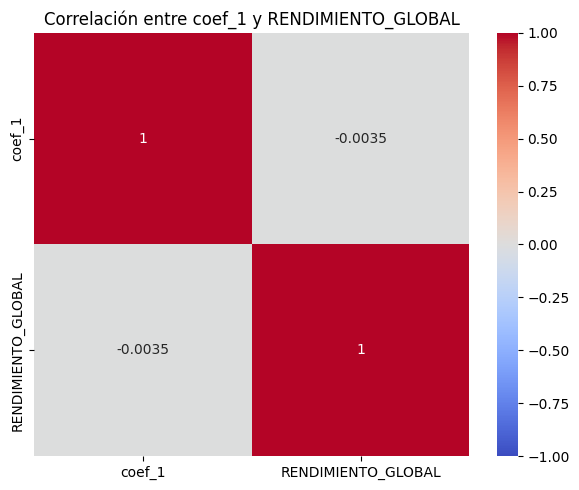

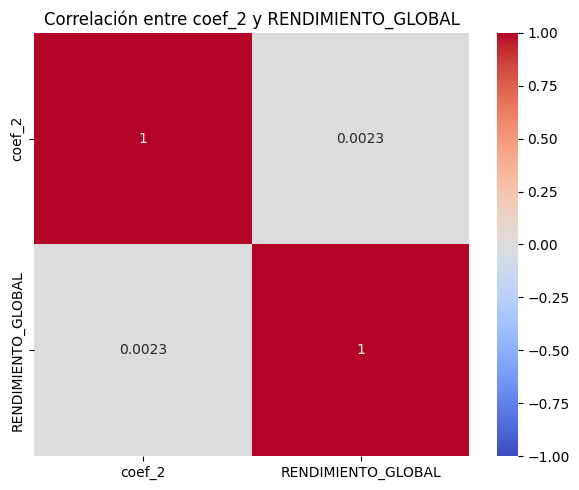

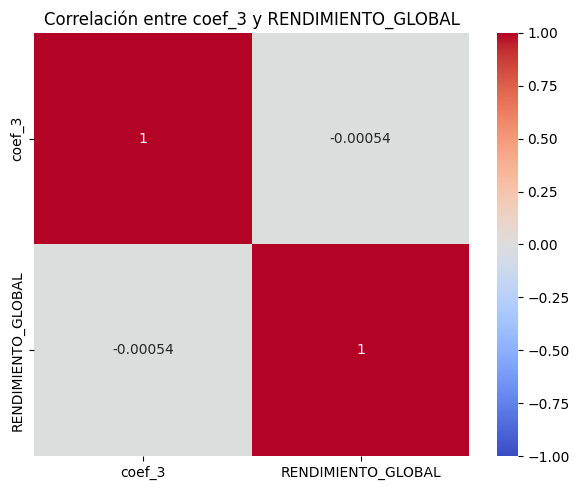

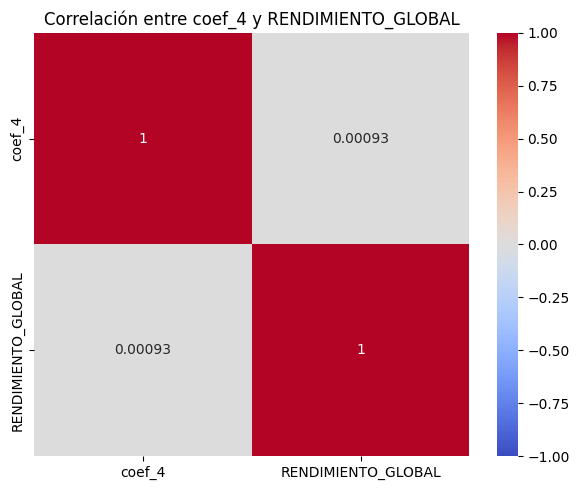

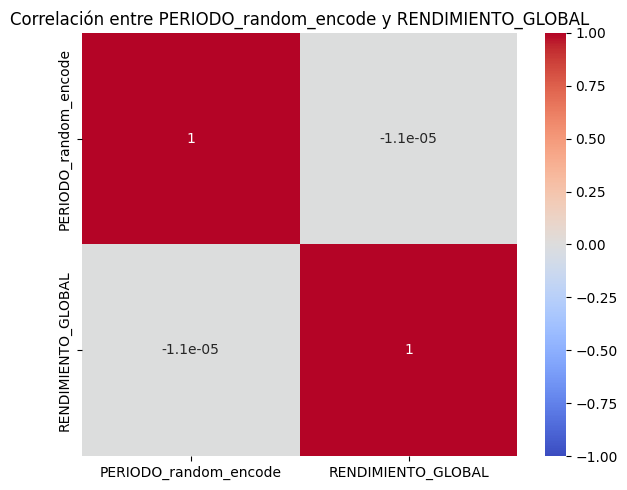

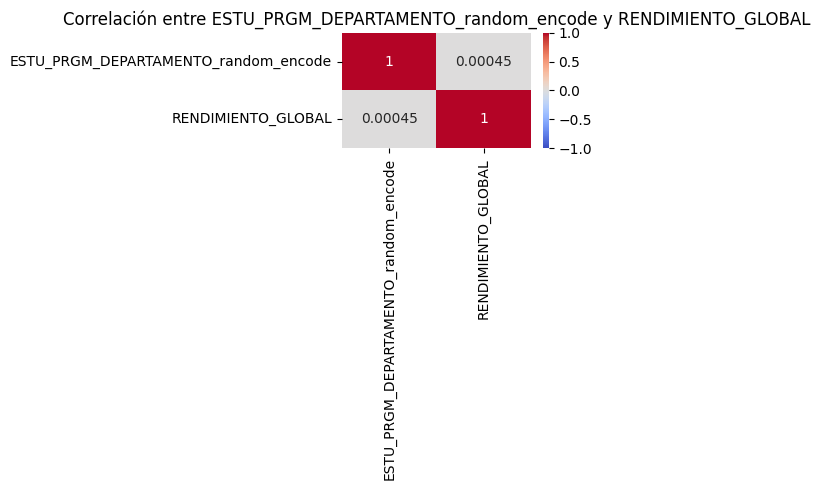

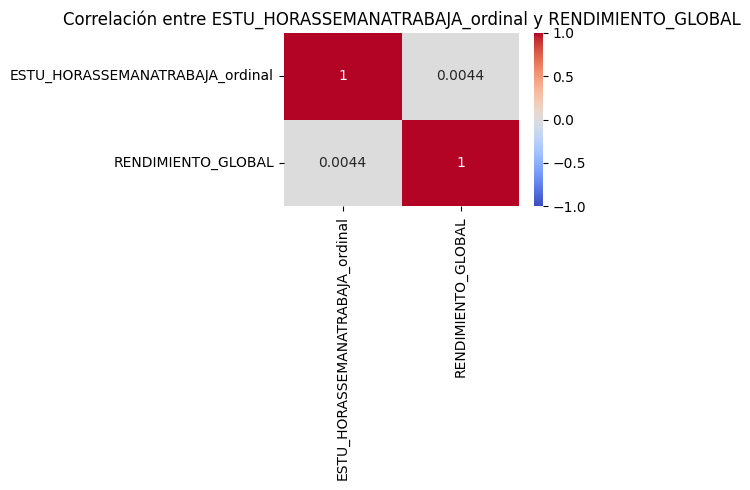

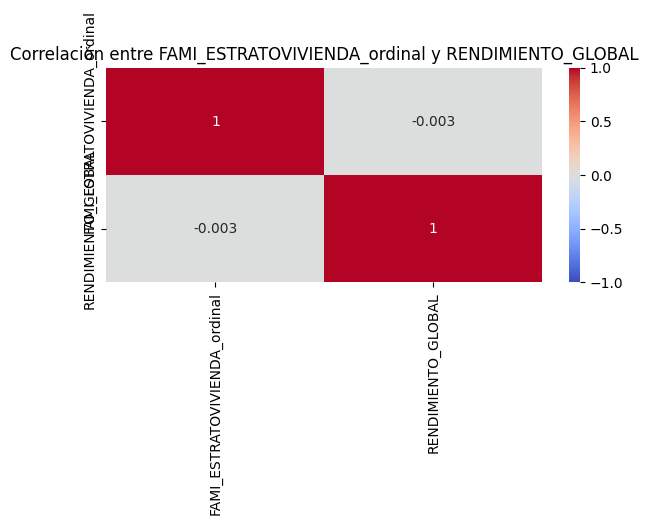

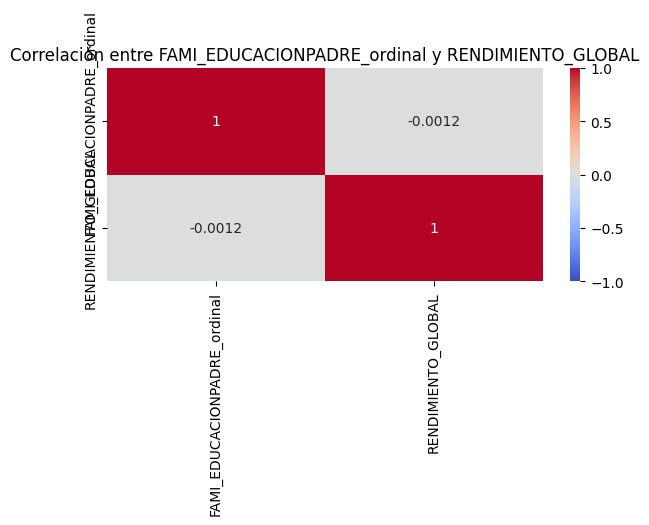

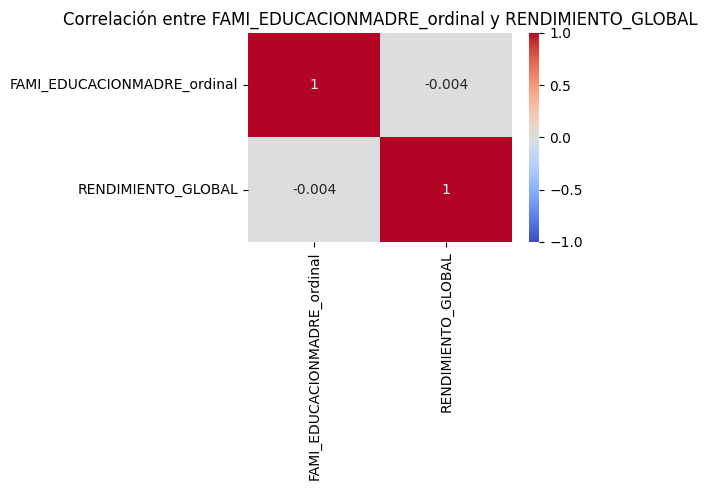

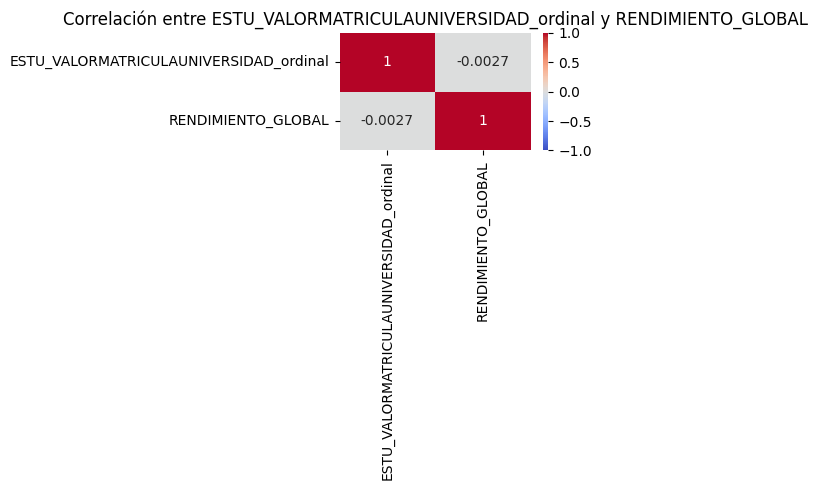

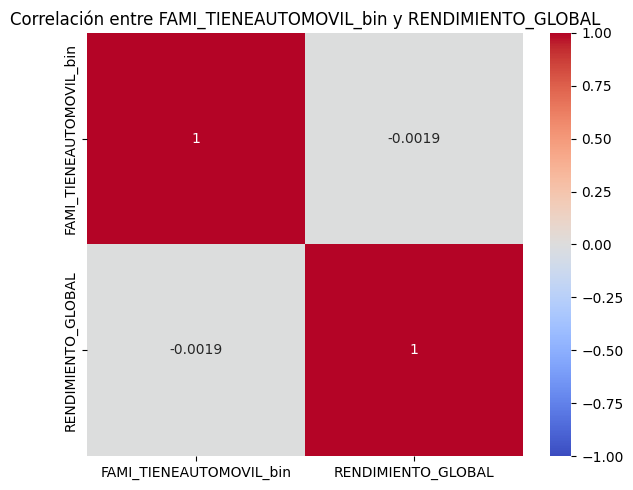

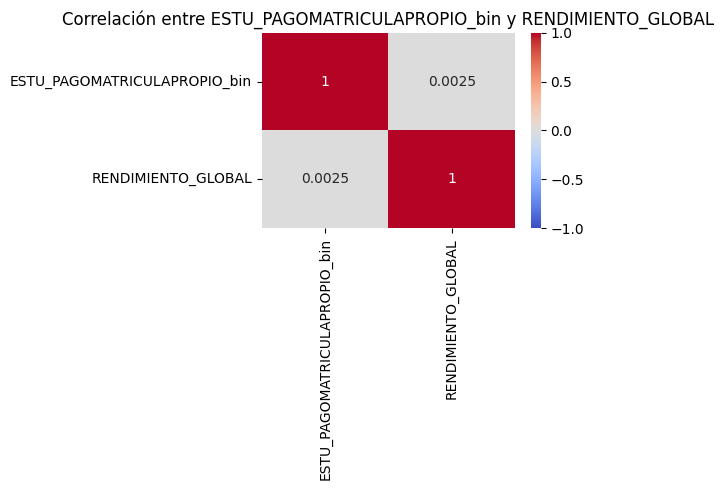

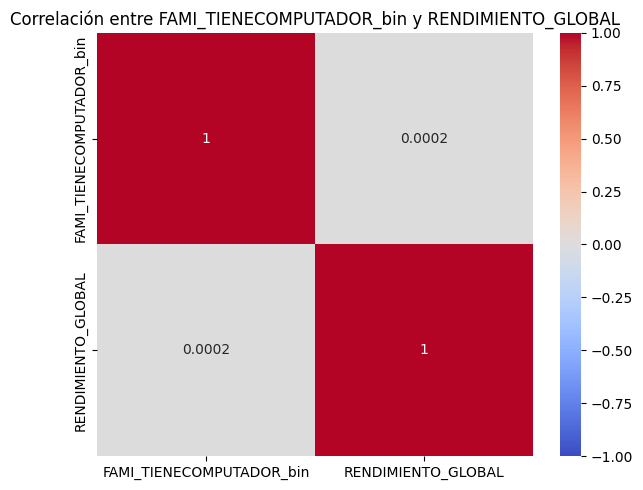

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas if not already imported

for i in data_test_Preprocesado.columns.tolist():
  plt.figure(figsize=(8, 6))
  # Create a temporary DataFrame with the current column and the Target series
  temp_df = pd.concat([data_test_Preprocesado[i], Target2.rename('RENDIMIENTO_GLOBAL')], axis=1)
  # Calculate and plot the correlation heatmap for the temporary DataFrame
  sns.heatmap(temp_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(f"Matriz de correlación entre {i} y RENDIMIENTO_GLOBAL")
  plt.show()

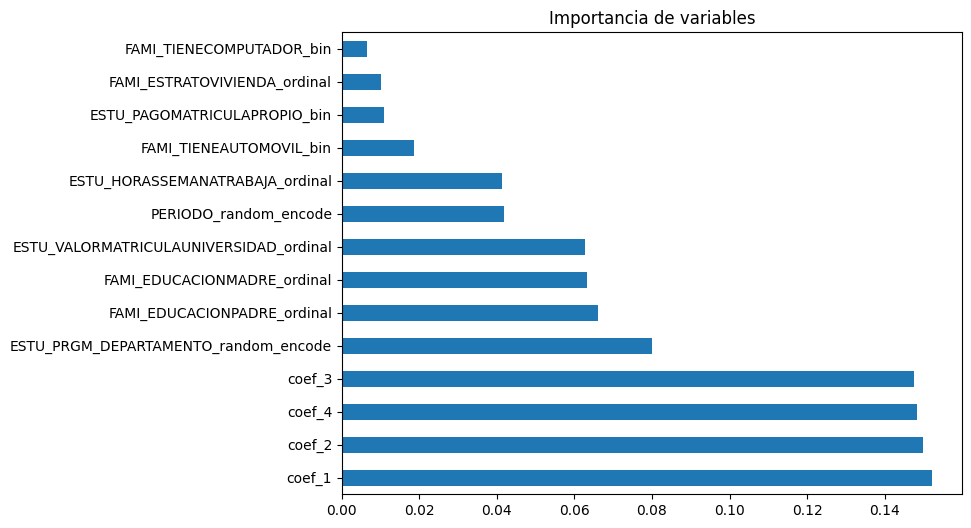

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf = RandomForestClassifier()
rf.fit(data_test_Preprocesado, Target)

importances = pd.Series(rf.feature_importances_, index=data_test_Preprocesado.columns)
importances.nlargest(15).plot(kind='barh', figsize=(8, 6), title="Importancia de variables")
plt.show()

In [ ]:
data_test_copy_mediana=pd.get_dummies(data_test_copy_mediana, columns=['ESTU_PRGM_DEPARTAMENTO'])
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

data_test_copy_mediana[columnas_categoricas[1:4]] = encoder.fit_transform(data_test_copy_mediana[columnas_categoricas[1:4]])
data_test_copy_mediana[["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"]]=encoder.fit_transform(data_test_copy_mediana[["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"]])

le = LabelEncoder()
for i in ['FAMI_TIENEAUTOMOVIL', 'ESTU_PAGOMATRICULAPROPIO',"FAMI_TIENECOMPUTADOR"]:
  data_test_copy_mediana[i] = le.fit_transform(data_test_copy_mediana[i])

In [ ]:
print(data_test_copy_mediana.info())

<class 'pandas.core.frame.DataFrame'>
Index: 296786 entries, 550236 to 792650
Data columns (total 34 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ESTU_VALORMATRICULAUNIVERSIDAD          296786 non-null  float64
 1   ESTU_HORASSEMANATRABAJA                 296786 non-null  float64
 2   FAMI_ESTRATOVIVIENDA                    296786 non-null  float64
 3   FAMI_EDUCACIONPADRE                     296786 non-null  float64
 4   FAMI_TIENEAUTOMOVIL                     296786 non-null  int64  
 5   ESTU_PAGOMATRICULAPROPIO                296786 non-null  int64  
 6   FAMI_TIENECOMPUTADOR                    296786 non-null  int64  
 7   FAMI_EDUCACIONMADRE                     296786 non-null  float64
 8   coef_1                                  296786 non-null  float64
 9   coef_2                                  296786 non-null  float64
 10  coef_3                                  2967

In [ ]:
data_test_copy_drop[columnas_drop[0:4]] = encoder.fit_transform(data_test_copy_drop[columnas_drop[0:4]])

#*Verficacion de igualdad de columnas*

In [ ]:
print(f"el porcentaje de datos perdidos en entrenamiento por las filas  eliminadas es: {100*(data_train.shape[0]-data_train_copy_drop.shape[0])/data_train.shape[0]:.3f} %")
print(f"el porcentaje de datos perdidos en testeo por las filas  eliminadas es: {100*(data_test.shape[0]-data_test_copy_drop.shape[0])/data_test.shape[0]:.3f} %")

el porcentaje de datos perdidos en entrenamiento por las filas  eliminadas es: 9.185 %
el porcentaje de datos perdidos en testeo por las filas  eliminadas es: 9.235 %


In [ ]:
# Comparar las columnas y obtener las que no se repiten
columnas_unicas_train = set(data_train_copy_mediana.columns) - set(data_test_copy_mediana.columns)
columnas_unicas_test = set(data_test_copy_mediana.columns) - set(data_train_copy_mediana.columns)

# Mostrar los resultados
print(f"Columnas que existen en Train pero no Test: {list(columnas_unicas_train)[0]}")
print(f"Columnas que existen en Test pero no Train: {list(columnas_unicas_test)[0] if columnas_unicas_test else 0}")

Columnas que existen en Train pero no Test: RENDIMIENTO_GLOBAL
Columnas que existen en Test pero no Train: 0


In [ ]:
# Comparar las columnas y obtener las que no se repiten
columnas_unicas_train_d = set(data_train_copy_drop.columns) - set(data_test_copy_drop.columns)
columnas_unicas_test_d = set(data_test_copy_drop.columns) - set(data_train_copy_drop.columns)

# Mostrar los resultados
print(f"Columnas que existen en Train pero no Test: {list(columnas_unicas_train_d)}")
print(f"Columnas que existen en Test pero no Train: {list(columnas_unicas_test_d)[0] if columnas_unicas_test_d else 0}")

Columnas que existen en Train pero no Test: ['RENDIMIENTO_GLOBAL']
Columnas que existen en Test pero no Train: 0


## DATAFRAMEs PERO CON DUMMIES

In [ ]:
data_train_copy_mediana_dummines=data_train_copy_mediana.copy()
data_test_copy_mediana_dummines=data_test_copy_mediana.copy()

data_train_copy_drop_dummines=data_train_copy_drop.copy()
data_test_copy_drop_dummines=data_test_copy_drop.copy()
data_train_copy_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628896 entries, 904256 to 933374
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ESTU_VALORMATRICULAUNIVERSIDAD          628896 non-null  float64
 1   ESTU_HORASSEMANATRABAJA                 628896 non-null  float64
 2   FAMI_ESTRATOVIVIENDA                    628896 non-null  float64
 3   FAMI_EDUCACIONPADRE                     628896 non-null  float64
 4   FAMI_TIENEAUTOMOVIL                     628896 non-null  int64  
 5   ESTU_PAGOMATRICULAPROPIO                628896 non-null  int64  
 6   FAMI_TIENECOMPUTADOR                    628896 non-null  int64  
 7   FAMI_EDUCACIONMADRE                     628896 non-null  float64
 8   RENDIMIENTO_GLOBAL                      628896 non-null  object 
 9   coef_1                                  628896 non-null  float64
 10  coef_2                                  6288

In [ ]:
data_train_copy_mediana_dummines= pd.get_dummies(data_train_copy_mediana_dummines, columns=columnas_categoricas)*1
data_test_copy_mediana_dummines= pd.get_dummies(data_test_copy_mediana_dummines, columns=columnas_categoricas)*1

columnas_categoricas = [col for col in columnas_categoricas if col in data_train_copy_drop.columns]
data_train_copy_drop_dummines= pd.get_dummies(data_train_copy_drop_dummines, columns=columnas_categoricas)*1
data_test_copy_drop_dummines= pd.get_dummies(data_test_copy_drop_dummines, columns=columnas_categoricas)*1

In [ ]:
# Comparar las columnas y obtener las que no se repiten
columnas_unicas_train_d = set(data_train_copy_drop_dummines.columns) - set(data_test_copy_drop_dummines.columns)
columnas_unicas_test_d = set(data_test_copy_drop_dummines.columns) - set(data_train_copy_drop_dummines.columns)

# Mostrar los resultados
print(f"Columnas que existen en Train pero no Test: {list(columnas_unicas_train_d)}")
print(f"Columnas que existen en Test pero no Train: {list(columnas_unicas_test_d)[0] if columnas_unicas_test_d else 0}")

Columnas que existen en Train pero no Test: ['RENDIMIENTO_GLOBAL']
Columnas que existen en Test pero no Train: 0


In [ ]:
# Comparar las columnas y obtener las que no se repiten
columnas_unicas_train_d = set(data_train_copy_mediana_dummines.columns) - set(data_test_copy_mediana_dummines.columns)
columnas_unicas_test_d = set(data_test_copy_mediana_dummines.columns) - set(data_train_copy_mediana_dummines.columns)

# Mostrar los resultados
print(f"Columnas que existen en Train pero no Test: {list(columnas_unicas_train_d)}")
print(f"Columnas que existen en Test pero no Train: {list(columnas_unicas_test_d)[0] if columnas_unicas_test_d else 0}")

Columnas que existen en Train pero no Test: ['RENDIMIENTO_GLOBAL']
Columnas que existen en Test pero no Train: 0


In [ ]:
data_train_copy_mediana_dummines.head()

,PERIODO,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,ESTU_PRGM_DEPARTAMENTO_ANTIOQUIA,ESTU_PRGM_DEPARTAMENTO_ARAUCA,ESTU_PRGM_DEPARTAMENTO_ATLANTICO,...,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_No Aplica,FAMI_EDUCACIONMADRE_No sabe,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta
ID,,,,,,,,,,,,,,,,,,,,,
904256,20212,medio-alto,0.322,0.208,0.310,0.267,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
645256,20212,bajo,0.311,0.215,0.292,0.264,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
308367,20203,bajo,0.297,0.214,0.305,0.264,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
470353,20195,alto,0.485,0.172,0.252,0.190,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
989032,20212,medio-bajo,0.316,0.232,0.285,0.294,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
data_train_copy_drop_dummines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628896 entries, 904256 to 933374
Data columns (total 76 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   RENDIMIENTO_GLOBAL                      628896 non-null  object 
 1   coef_1                                  628896 non-null  float64
 2   coef_2                                  628896 non-null  float64
 3   coef_3                                  628896 non-null  float64
 4   coef_4                                  628896 non-null  float64
 5   ESTU_PRGM_DEPARTAMENTO_ANTIOQUIA        628896 non-null  int64  
 6   ESTU_PRGM_DEPARTAMENTO_ATLANTICO        628896 non-null  int64  
 7   ESTU_PRGM_DEPARTAMENTO_BOGOTÁ           628896 non-null  int64  
 8   ESTU_PRGM_DEPARTAMENTO_BOLIVAR          628896 non-null  int64  
 9   ESTU_PRGM_DEPARTAMENTO_BOYACA           628896 non-null  int64  
 10  ESTU_PRGM_DEPARTAMENTO_CALDAS           6288

## Guradamos los datos obtenidos

In [ ]:
# Ruta base en tu Google Drive
ruta = '/content/drive/MyDrive/Inteligencia_Artificial_2025-1/DATA/'

In [ ]:
import os
os.makedirs(ruta, exist_ok=True)  # Crear carpeta si no existe

# Guardar los archivos en Drive
data_train_copy_mediana.to_csv(ruta + 'train_with_median.csv', index=False)
data_test_copy_mediana.to_csv(ruta + 'test_with_median.csv', index=False)
data_train_copy_drop.to_csv(ruta + 'train_with_drop.csv', index=False)
data_test_copy_drop.to_csv(ruta + 'test_with_drop.csv', index=False)
data_train_copy_mediana_dummines.to_csv(ruta + 'data_train_copy_mediana_dummines.csv', index=False)
data_test_copy_mediana_dummines.to_csv(ruta + 'data_test_copy_mediana_dummines.csv', index=False)

print("Todos los archivos han sido guardados en Google Drive.")


Todos los archivos han sido guardados en Google Drive.


In [ ]:
dt =data_train_copy_drop.copy()
dt.pop('RENDIMIENTO_GLOBAL')
x_train_drop=dt.iloc[:,0:10]
x_test_drop=data_test_copy_drop.iloc[:,0:10]
print(y_label_drop.shape)
print(x_train_drop.shape)
print(x_test_drop.shape)
from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar el escalador SOLO con el conjunto de entrenamiento
scaler.fit(x_train_drop)

# Transformar tanto el entrenamiento como el test
x_train_scaled = scaler.transform(x_train_drop)
x_test_scaled = scaler.transform(x_test_drop)

(628896,)
(628896, 10)
(269379, 10)


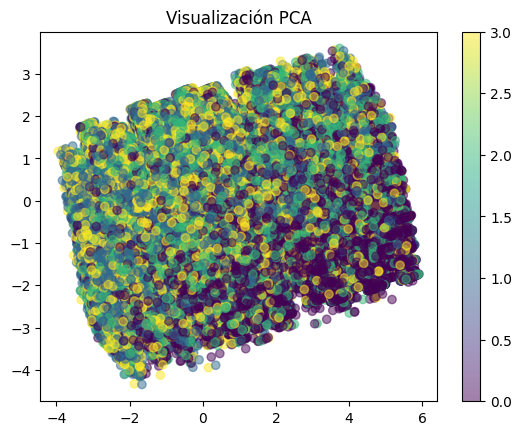

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=7)
X_pca = pca.fit_transform(x_train_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_label_drop, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('Visualización PCA')
plt.show()